In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tscopulas.models import gaussian, vine

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load data
data = pd.read_csv('regime_data.csv', index_col='date')
# Top 100 U.S. stocks by market captilization on January 1st 2018
TOP100 = [
    'AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB', 'BABA', 'BRK.B', 'JNJ', 'XOM', 'JPM', 'WMT', 'BAC', 'WFC', 'V',
    'PG', 'CVX', 'TSM', 'PFE', 'UNH', 'T', 'HD', 'VZ', 'BUD', 'ORCL', 'NVS', 'KO', 'C', 'INTC', 'TM', 'CSCO',
    'GE', 'UL', 'CMCSA', 'PM', 'DD', 'MA', 'PEP', 'DIS', 'BA', 'MRK', 'ABBV', 'BP', 'IBM', 'MMM', 'MCD', 
    'NVDA', 'SAP', 'AMGN', 'NVO', 'MO', 'SNY', 'PTR', 'RY', 'HON', 'MDT', 'AVGO', 'GSK', 'ACN', 'UPS', 'BMY',
    'GILD', 'TXN', 'KHC', 'RTX', 'ABT', 'RAI', 'LLY', 'GS', 'UNP', 'USB', 'MS', 'SNP', 'LMT', 'SLB', 'NKE', 
    'NFLX', 'PYPL', 'AZN', 'BIDU', 'VOD', 'COST', 'AXP', 'CAT', 'SBUX', 'BKNG', 'QCOM', 'CELG', 'CHTR', 'TMO',
    'CRM', 'TWX', 'BLK', 'DD1', 'ASML', 'ADBE', 'NEE', 'LOW', 'CB', 'WBA', 'CVS'
]
# Calculate regimes from sharpe ratios
ret = data.pct_change(1).iloc[1:, :]
mean = ret.rolling(40).mean().iloc[39:, :].mean(axis=1)
std_dev = ret.rolling(40).mean().iloc[39:, :].std(axis=1) 
sharpe = mean / std_dev

def get_regime(sharpe):
    """Classify regime from sharpe ratio"""
    if sharpe >= 0.5:
        return "bull"
    if sharpe >= 0:
        return "neutral"
    return "bear"

# Get the returns data for each market regime
regimes_data = ret.iloc[39:, :]
regimes_data['regime'] = sharpe.apply(get_regime)
regimes_dict = {regime: df.drop('regime', axis=1) for regime, df in regimes_data.groupby('regime')}
regimes_data['regime'].value_counts()

bull       1232
neutral    1188
bear        812
Name: regime, dtype: int64

In [8]:
import time
from collections import defaultdict
regimes_synth = {"gaussian": defaultdict(), "vine": defaultdict()}

for regime, data in regimes_dict.items():
    data.fillna(0, inplace=True)
    print(f"fitting gaussian on {regime} regime data with {data.shape[0]} points...")
    start = time.time()
    gauss = gaussian.Gaussian(1)
    gauss.fit(data)
    print(f"Gaussian fit in ----- {time.time() - start} seconds -----")
    regimes_synth["gaussian"][f"{regime}_model"] = gauss
    print(f"fitting vine on {regime} regime data with {data.shape[0]} points...")
    start = time.time()
    vi = vine.Vine(1, vine_type="center")
    print(f"Vine fit in ----- {time.time() - start} seconds -----")
    vi.fit(data)
    regimes_synth["vine"][f"{regime}_model"] = vi
    
    print("sampling gaussian...")
    start = time.time()
    regimes_synth["gaussian"][regime] = gauss.sample(500, "AAPL", 1)
    print(f"Sampled Gaussian in ----- {time.time() - start} seconds -----")
    print("sampling vine...")
    start = time.time()
    regimes_synth["vine"][regime] = vi.sample(500, "AAPL", 1)
    print(f"Sampled Vine in ----- {time.time() - start} seconds -----")

regimes_synth_data = {
    copula: {regime: data for regime, data in synth.items() if not regime.endswith('_model')}
    for copula, synth in regimes_synth.items()
}

fitting gaussian on bear regime data with 812 points...
fitting vine on bear regime data with 812 points...
Vine fit in ----- 0.0033631324768066406 seconds -----
sampling gaussian...
Sampled Gaussian in ----- 4.589045763015747 seconds -----
sampling vine...
Sampled Vine in ----- 554.2082455158234 seconds -----
fitting gaussian on bull regime data with 1232 points...
fitting vine on bull regime data with 1232 points...
Vine fit in ----- 3.933906555175781e-05 seconds -----
sampling gaussian...
Sampled Gaussian in ----- 25.3304340839386 seconds -----
sampling vine...
Sampled Vine in ----- 662.1098036766052 seconds -----
fitting gaussian on neutral regime data with 1188 points...
fitting vine on neutral regime data with 1188 points...
Vine fit in ----- 3.695487976074219e-05 seconds -----
sampling gaussian...
Sampled Gaussian in ----- 23.981311798095703 seconds -----
sampling vine...
Sampled Vine in ----- 650.0214095115662 seconds -----


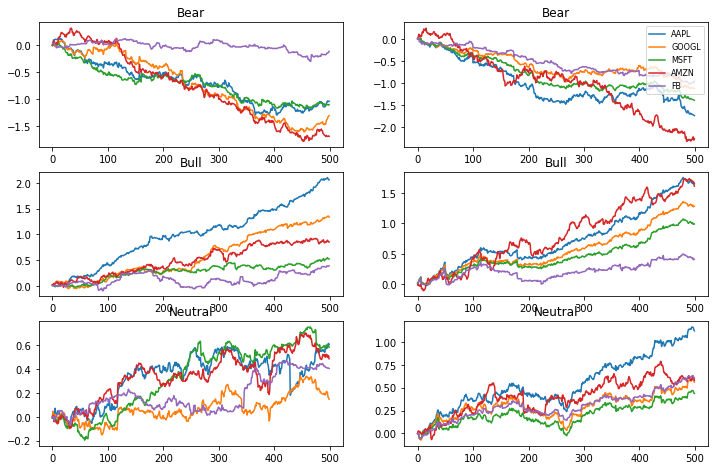

In [84]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
axes1, axes2 = axes.T
plt.subplots_adjust(bottom=-0.1)

for ax, (regime, synth) in zip(axes1, regimes_synth_data["gaussian"].items()):
    ax.plot(synth[['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB']].cumsum())
    ax.set_title(regime.title())
    
for ax, (regime, synth) in zip(axes2, regimes_synth_data["vine"].items()):
    ax.plot(synth[['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB']].cumsum())
    ax.set_title(regime.title())

axes2[0].legend(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'], loc='upper right',fontsize=8)
fig.show()

bear
Synthetic
Real
Difference
bull
Synthetic
Real
Difference
neutral
Synthetic
Real
Difference


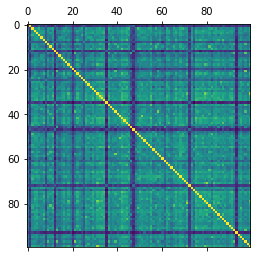

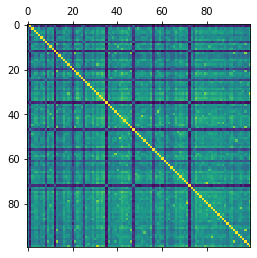

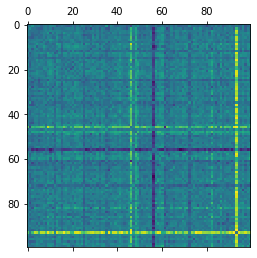

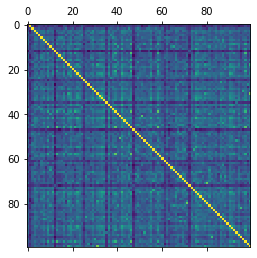

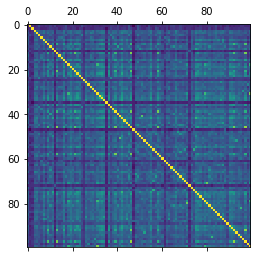

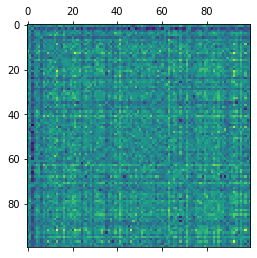

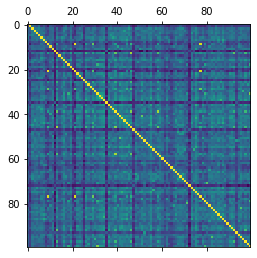

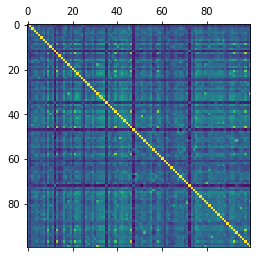

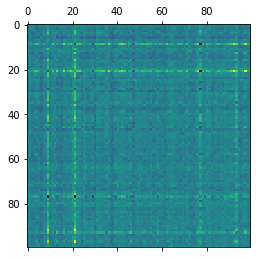

In [92]:
for regime, synth in regimes_synth_data['gaussian'].items():
    plt.matshow(synth.corr())
    real = regimes_dict[regime]
    plt.matshow(real.corr())
    plt.matshow(real.corr() - synth.corr())
#     plt.hist((real.corr() - synth.corr()).values.flatten(), bins=40)

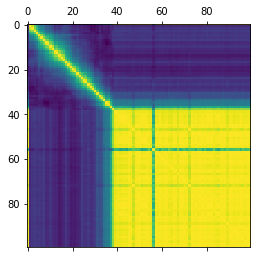

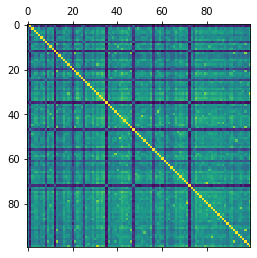

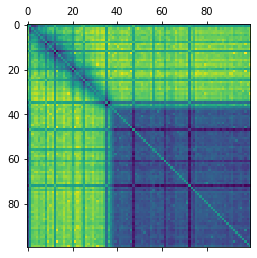

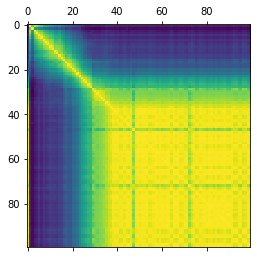

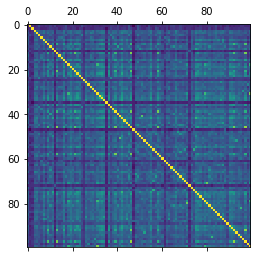

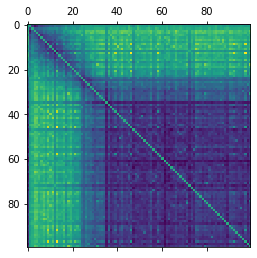

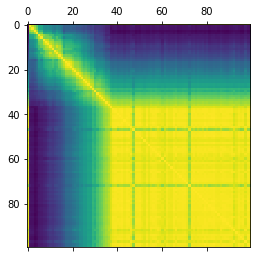

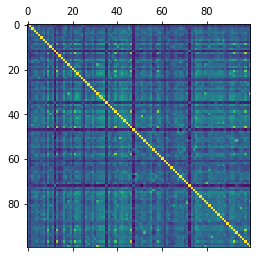

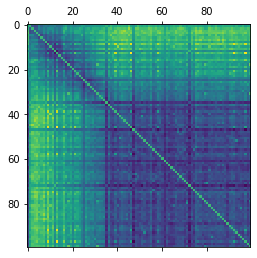

In [93]:
for regime, synth in regimes_synth_data['vine'].items():
    plt.matshow(synth.corr())
    real = regimes_dict[regime]
    plt.matshow(real.corr())
    plt.matshow(real.corr() - synth.corr())